In [1]:
import dask.distributed as dsk
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

clnt = dsk.Client()
clnt

Client Scheduler: tcp://127.0.0.1:36535 Dashboard: /proxy/8787/status,Cluster Workers: 4 Cores: 16 Memory: 64.00 GiB


In [2]:
uas = {}
vas = {}
uas['ERA-Interim'] = xr.open_dataset('../data/uas-erai-monthly-1979_2015.nc')['uas'].sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01')).mean('time')
vas['ERA-Interim'] = xr.open_dataset('../data/vas-erai-monthly-1979_2015.nc')['vas'].sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01')).mean('time')
uas['ERA5'] = xr.open_dataset('../data/uas-era5-monthly-1979_2015.nc')['u10'].sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01')).mean('time')
vas['ERA5'] = xr.open_dataset('../data/vas-era5-monthly-1979_2015.nc')['v10'].sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01')).mean('time')
uas['CFSR'] = xr.open_dataset('../data/uas-cfsr-monthly-1979_2015.nc')['ua'].sel(lat = slice(None, -50)).mean('time')
vas['CFSR'] = xr.open_dataset('../data/vas-cfsr-monthly-1979_2015.nc')['va'].sel(lat = slice(None, -50)).mean('time')
uas['JRA55'] = xr.open_dataset('../data/uas-jra55-monthly-1979_2015.nc')['uas'].sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01')).mean('time')
vas['JRA55'] = xr.open_dataset('../data/vas-jra55-monthly-1979_2015.nc')['vas'].sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01')).mean('time')
uas['CMIP6'] = xr.open_dataset('../data/uas-cmip6-monthly-1958_2015.nc')['uas'].sel(time = slice('1979-01-01', '2015-01-01')).mean('time')
vas['CMIP6'] = xr.open_dataset('../data/vas-cmip6-monthly-1958_2015.nc')['vas'].sel(time = slice('1979-01-01', '2015-01-01')).mean('time')

In [34]:
def find_min_lat(ws, n):
    
    # mask peninsula to avoid anomalies there:
    peninsula_mask = ws.where(ws['lat']<-68).where(ws['lon']>-75).where(ws['lon']<-64)*0
    peninsula_mask = peninsula_mask.fillna(1)
    peninsula_mask = peninsula_mask.where(peninsula_mask==1)
    latitude = ws['lat']
    longitude = ws['lon']

    # mask outside of 60 and 80S:
    speed_mask = ws.where(ws['lat']<-60).where(ws['lat']>-80)

    # first pass at latitude indices where speed is a minimum:
    min_lat_indices = (peninsula_mask*speed_mask).argmin(dim = 'lat')

    # remove large latitude jumps in min_lat_indices:
    filtered_min_lat_indices = min_lat_indices.copy()
    for i in range(len(longitude)-1):
        if np.abs(min_lat_indices[i+1] - filtered_min_lat_indices[i]) > n:
            filtered_min_lat_indices[i+1] = np.maximum(min_lat_indices[i+1],filtered_min_lat_indices[i])

    # and apply a smoothing:
    smoothed_min_lat_indices = np.ceil((filtered_min_lat_indices.roll(lon=3,roll_coords=False) + \
                                        filtered_min_lat_indices.roll(lon=2,roll_coords=False) + \
                                        filtered_min_lat_indices.roll(lon=1,roll_coords=False) + \
                                        filtered_min_lat_indices.roll(lon=-1,roll_coords=False) + \
                                        filtered_min_lat_indices.roll(lon=-2,roll_coords=False) + \
                                        filtered_min_lat_indices.roll(lon=-3,roll_coords=False) + filtered_min_lat_indices)/7)

    # pick out latitude values:
    smoothed_min_lat = latitude.isel(lat=smoothed_min_lat_indices.astype(int))
    lat_xarray = xr.DataArray(smoothed_min_lat, dims = {'lon'}, coords = {'lon':longitude})
    #lat_xarray = xr.where((lat_xarray['lon'] < -64) & (lat_xarray['lon'] > -70), np.nan, lat_xarray)
    
    return lat_xarray

# Line to create mask

In [60]:
uas_int = uas['ERA-Interim'].interp(lon = np.arange(-180, 179.2, .2), lat = np.arange(-90, -50.2, .2))
vas_int = vas['ERA-Interim'].interp(lon = np.arange(-180, 179.2, .2), lat = np.arange(-90, -50.2, .2))

In [3]:
ws = np.sqrt(uas_int**2+vas_int**2)

In [4]:
div_line = find_min_lat(ws)

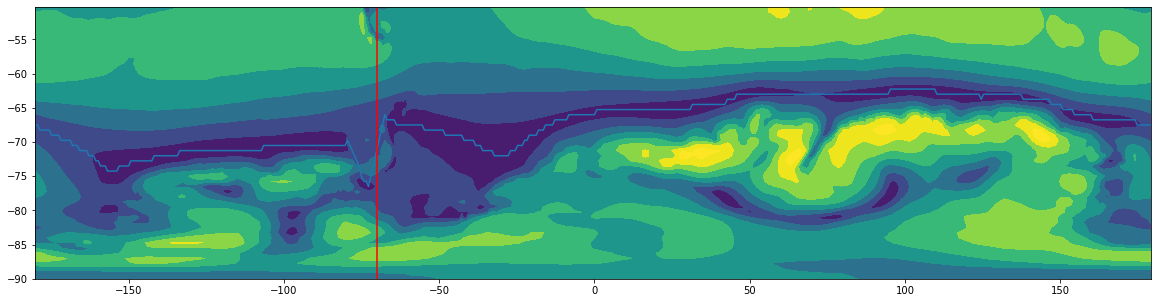

In [5]:
plt.figure(figsize = (20,5))
plt.contourf(uas['lon'], uas['lat'], np.sqrt(uas**2+vas**2), vmin = 0, vmax = 10)
plt.plot(div_line['lon'], div_line)
plt.axvline(x = -70, color = 'r')

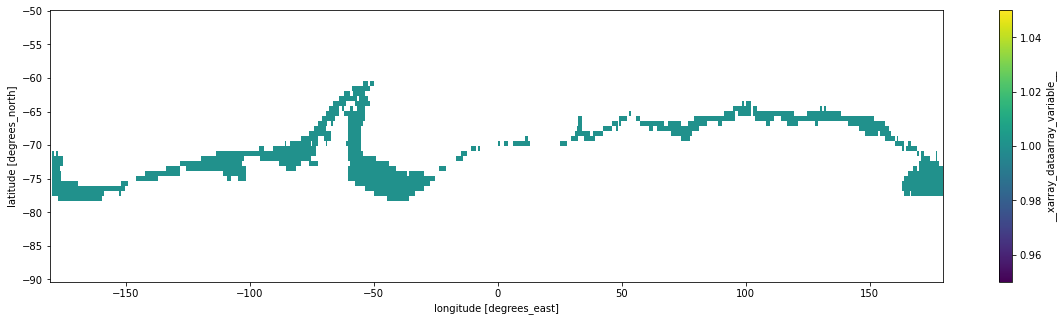

In [6]:
shelf_mask = xr.open_dataset('../data/shelf_mask_1500misobath.nc')['__xarray_dataarray_variable__']
shelf_mask = shelf_mask.rename(({'xu_ocean':'lon', 'yu_ocean':'lat'}))
shelf_mask['_lon_adj'] = xr.where(shelf_mask['lon'] < -180, shelf_mask['lon'] + 360, shelf_mask['lon'])
shelf_mask = shelf_mask.swap_dims({'lon': '_lon_adj'})
shelf_mask = shelf_mask.sel(**{'_lon_adj': sorted(shelf_mask._lon_adj)}).drop('lon')
shelf_mask = shelf_mask.rename({'_lon_adj': 'lon'})
shelf_mask_int = shelf_mask.interp(lon = uas['lon'], lat = uas['lat'])
shelf_mask_int.plot(figsize=(20,5))

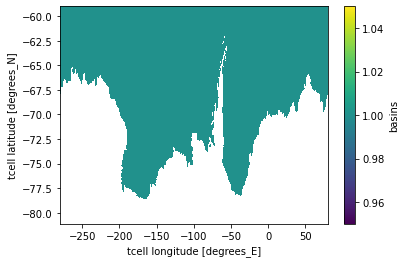

In [7]:
coast_mask = xr.open_dataset('~/g_e14/misc/Antarctic_shelf_basins.nc')['basins']
coast_mask = xr.where(~np.isnan(coast_mask), 1, np.nan)
coast_mask.plot()

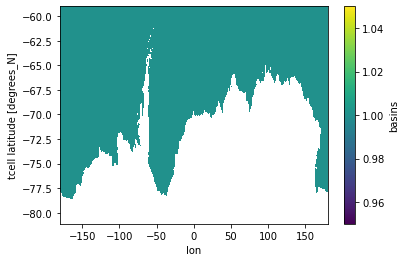

In [8]:
coast_mask = coast_mask.rename(({'xt_ocean':'lon', 'yt_ocean':'lat'}))
coast_mask['_lon_adj'] = xr.where(coast_mask['lon'] < -180, coast_mask['lon'] + 360, coast_mask['lon'])
coast_mask = coast_mask.swap_dims({'lon': '_lon_adj'})
coast_mask = coast_mask.sel(**{'_lon_adj': sorted(coast_mask._lon_adj)}).drop('lon')
coast_mask = coast_mask.rename({'_lon_adj': 'lon'})
coast_mask.plot()

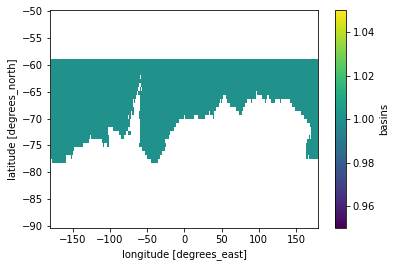

In [9]:
coast_mask = coast_mask.interp(lon = uas['lon'], lat = uas['lat'])
coast_mask.plot()

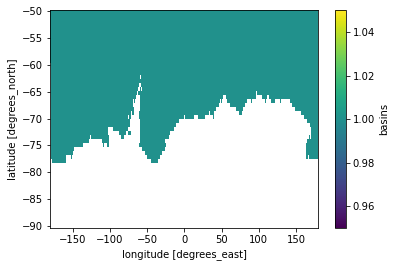

In [10]:
coast_mask = coast_mask.where(coast_mask['lat']<=-59.9, 1)
coast_mask.plot()

In [11]:
mask = np.zeros(np.shape(coast_mask))*np.nan
mask = xr.DataArray(mask, dims = coast_mask.dims, coords = coast_mask.coords)

In [12]:
mask_south_divline = xr.where(mask['lat']<div_line, 1, np.nan)

In [13]:
mask_south_divline_nocoast = xr.where(np.isnan(coast_mask), np.nan, mask_south_divline)

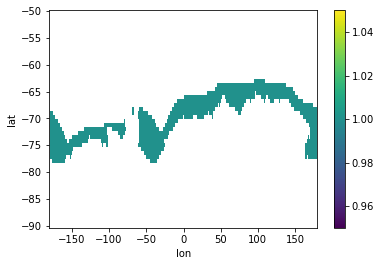

In [14]:
mask_south_divline_nocoast.plot()

Ahora agregar la puta peninsula

In [15]:
mask_with_wap = np.nansum(np.dstack((mask_south_divline_nocoast.values, shelf_mask_int.values)), 2)

In [16]:
mask_with_wap = xr.DataArray(mask_with_wap, dims = coast_mask.dims, coords = coast_mask.coords)

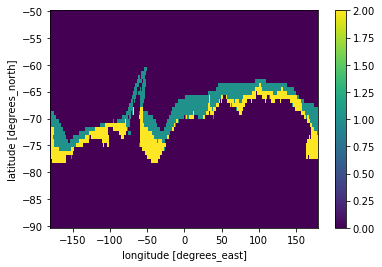

In [17]:
mask_with_wap.plot()

In [18]:
mask_with_wap = xr.where(mask_with_wap!=0, 1, np.nan)

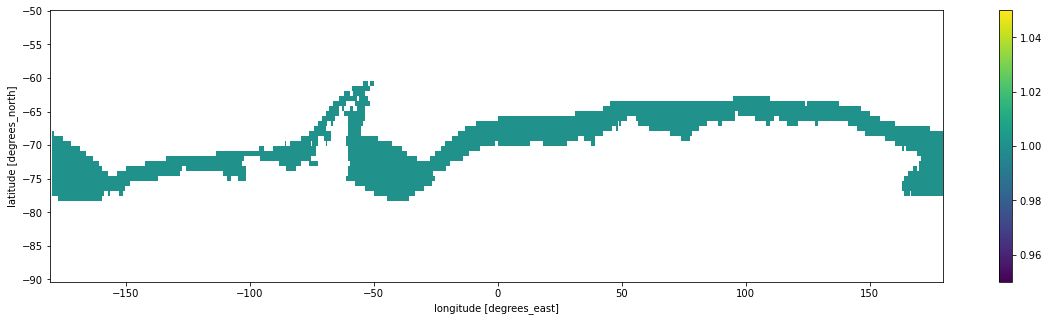

In [19]:
mask_with_wap.plot(figsize=(20,5))

In [20]:
mask_with_wap.to_netcdf('../data/zero_div_line_with_wap_mask_lowres.nc')

In [24]:
mask_high = xr.open_dataset('../data/zero_div_line_with_wap_mask.nc')['__xarray_dataarray_variable__']
mask_low = xr.open_dataset('../data/zero_div_line_with_wap_mask_lowres.nc')['__xarray_dataarray_variable__']

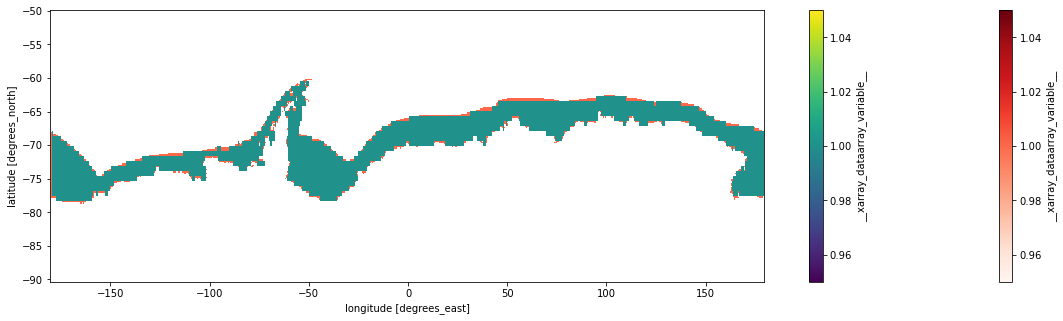

In [28]:
mask_high.plot(cmap = 'Reds', figsize=(20,5))
mask_low.plot()

# Line in all different products

In [11]:
mask = xr.open_dataset('../data/zero_div_line_with_wap_mask.nc')['__xarray_dataarray_variable__']
hu = xr.open_dataset('~/g_e14/misc/hu-01deg.nc')['hu'].sel(yu_ocean = slice(None, -50))
land_ice_mask = xr.where(np.isnan(hu.interp(yu_ocean = np.arange(-90, -50.1, .1))), 1, np.nan).interp(yu_ocean = np.arange(-90, -50.1, .1))
land_ice_mask = land_ice_mask.rename(({'xu_ocean':'lon', 'yu_ocean':'lat'}))
land_ice_mask['_lon_adj'] = xr.where(land_ice_mask['lon'] < -180, land_ice_mask['lon'] + 360, land_ice_mask['lon'])
land_ice_mask = land_ice_mask.swap_dims({'lon': '_lon_adj'})
land_ice_mask = land_ice_mask.sel(**{'_lon_adj': sorted(land_ice_mask._lon_adj)}).drop('lon')
land_ice_mask = land_ice_mask.rename({'_lon_adj': 'lon'})

In [5]:
ws = {}
for k in ['ERA-Interim', 'ERA5', 'CFSR', 'JRA55', 'CMIP6']:
    ws[k] = np.sqrt(uas[k]**2+vas[k]**2)

In [41]:
div_line = {}
for k, n in zip(['ERA-Interim', 'ERA5', 'CFSR', 'JRA55', 'CMIP6'], [4, 4, 5, 5, 4]):
    div_line[k] = find_min_lat(ws[k], n)

In [43]:
from palettable.tableau import Tableau_10

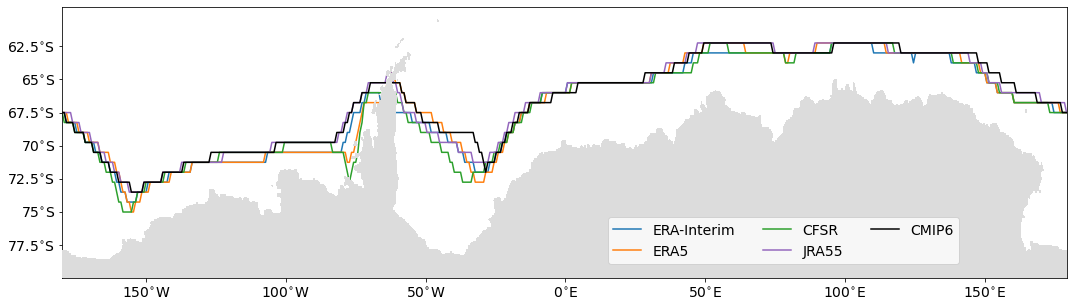

In [52]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (18, 5))
ax = fig.add_subplot()
ax.set_xlim([-180, 179.25])
ax.set_ylim([-80, -59.5])
ax.set_yticks(np.arange(-77.5, -60, 2.5))
ax.set_yticklabels(['77.5$^{\circ}$S', '75$^{\circ}$S', '72.5$^{\circ}$S', '70$^{\circ}$S', 
                    '67.5$^{\circ}$S', '65$^{\circ}$S', '62.5$^{\circ}$S'])
ax.set_xticks(np.arange(-150, 200, 50))
ax.set_xticklabels(['150$^{\circ}$W', '100$^{\circ}$W', '50$^{\circ}$W', '0$^{\circ}$E', 
                    '50$^{\circ}$E', '100$^{\circ}$E', '150$^{\circ}$E'])
# Land
ax.contourf(land_ice_mask['lon'], land_ice_mask['lat'], land_ice_mask, colors = 'gainsboro', 
            linewidths = 0.5, zorder = 3)
    
for k, clr in zip(['ERA-Interim', 'ERA5', 'CFSR', 'JRA55', 'CMIP6'], [Tableau_10.mpl_colors[0], Tableau_10.mpl_colors[1], Tableau_10.mpl_colors[2], Tableau_10.mpl_colors[4], 'k']):
    ax.plot(div_line[k]['lon'], div_line[k], color = clr, label = k)
ax.legend(ncol = 3, bbox_to_anchor = (0.9, 0.25), fontsize = 14)
plt.savefig('../results/v4/figsup0.pdf', bbox_inches = 'tight')